In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
%load_ext tensorboard

In [3]:
a, b = 1, -1
sigma = 0.1
batch_size = 32
nb_batch = 400
xs = np.linspace(0, 4, batch_size*nb_batch)

rdms = np.random.normal(0,sigma, len(xs))
ys = (a * xs**2 + b*xs + rdms)


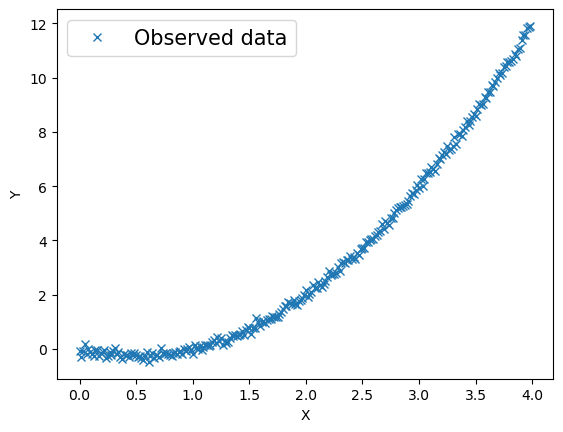

In [4]:
a_init, b_init = -1, 2

np.random.seed(0)
X_test = np.random.uniform(0, 4, 32)

plt.plot(xs[::50], ys[::50], ls='', marker='x', label='Observed data', alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(fontsize=15)

In [5]:
xs = np.expand_dims(xs, -1).astype('float32')
ys = np.expand_dims(ys, -1).astype('float32')
pytorch_xs = torch.from_numpy(xs)
pytorch_ys = torch.from_numpy(ys)
train = torch.utils.data.TensorDataset(pytorch_xs, pytorch_ys)
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)


## Model 

In [6]:
from torch.nn import functional as F
from torch import nn
from lightning import LightningModule, Trainer

In [7]:
class TorchDenseNet(LightningModule):

    def __init__(self):
        super().__init__()
        
        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Linear(1, 4)
        self.activ_1 = torch.nn.ReLU()
        self.layer_2 = torch.nn.Linear(4, 8)
        self.activ_2 = torch.nn.ReLU()
        self.layer_3 = torch.nn.Linear(8, 1)

    def forward(self, x):
        batch_size, channels = x.size()
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = self.activ_1(x)
        x = self.layer_2(x)
        x = self.activ_2(x)
        x = self.layer_3(x)
        
        return x
      
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("loss", loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.005)

In [8]:
net = TorchDenseNet()


In [9]:
logger = SummaryWriter("logs")
trainer = Trainer(max_epochs=5, log_every_n_steps=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(net, train_dataloader)

Missing logger folder: /Users/hbretonniere/work/Tutos/tuto_ml/ucsc_ml_intro/pytorch/polynomial_fit/lightning_logs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 8     
1 | activ_1 | ReLU   | 0     
2 | layer_2 | Linear | 40    
3 | activ_2 | ReLU   | 0     
4 | layer_3 | Linear | 9     
-----------------------------------
57        Trainable params
0         Non-trainable params
57        Total params
0.000     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/pytorch_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# Logs with tensorboard

In [16]:

parent_dir = 'lightning_logs/'
subdirectories = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]
sorted_subdirectories = sorted(subdirectories, key=lambda x: os.path.getctime(x), reverse=True)
latest_run = sorted_subdirectories[0] if sorted_subdirectories else None

%tensorboard --logdir {latest_run}

# plot the loss manually

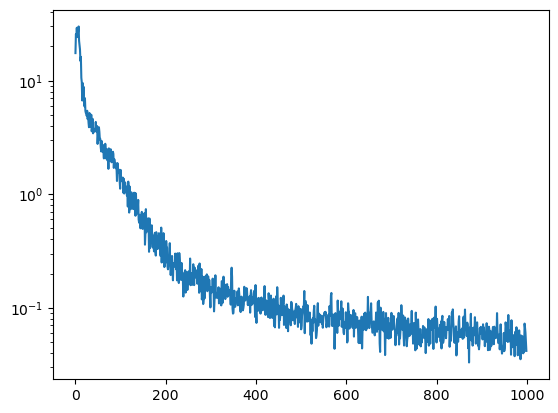

In [12]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator(latest_run)
event_acc.Reload()

# Get the loss values
loss_values = []
for scalar in event_acc.Scalars('loss'):
    loss_values.append(scalar.value)
plt.plot(loss_values)
plt.yscale('log')

In [13]:
test_features, test_labels = next(iter(train_dataloader))
out_test = net(test_features)

# Plot the result

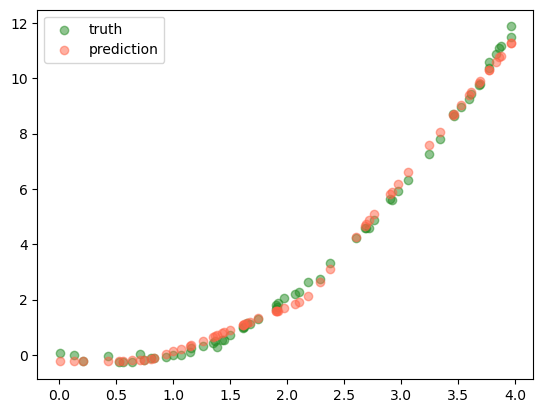

In [14]:
plt.scatter(test_features, test_labels, color='forestgreen', label='truth', alpha=0.5)
plt.scatter(test_features, out_test.detach().numpy(), color='tomato', label='prediction', alpha=0.5)
plt.legend()